In [ ]:
# %load HiddenMarkovModel.py
import numpy as np
from notes_utilities import randgen, log_sum_exp, normalize_exp, normalize

class HMM(object):
    def __init__(self, pi, A, B):
        # p(x_0)
        self.pi = pi
        # p(x_k|x_{k-1})
        self.A = A
        # p(y_k|x_{k})
        self.B = B
        # Number of possible latent states at each time
        self.S = pi.shape[0]
        # Number of possible observations at each time
        self.R = B.shape[0]
        self.logB = np.log(self.B)
        self.logA = np.log(self.A)
        self.logpi = np.log(self.pi)
    
    def set_param(self, pi=None, A=None, B=None):
        if pi is not None:
            self.pi = pi
            self.logpi = np.log(self.pi)

        if A is not None:
            self.A = A
            self.logA = np.log(self.A)

        if B is not None:
            self.B = B
            self.logB = np.log(self.B)

    @classmethod
    def from_random_parameters(cls, S=3, R=5):
        A = np.random.dirichlet(0.7*np.ones(S),S).T
        B = np.random.dirichlet(0.7*np.ones(R),S).T
        pi = np.random.dirichlet(0.7*np.ones(S)).T
        return cls(pi, A, B)
        
    def __str__(self):
        s = "Prior:\n" + str(self.pi) + "\nA:\n" + str(self.A) + "\nB:\n" + str(self.B)
        return s
    
    def __repr__(self):
        s = self.__str__()
        return s

    def predict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(self.A,np.exp(lp-lstar)))

    def postdict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(np.exp(lp-lstar), self.A))

    def predict_maxm(self, lp):
        return np.max(self.logA + lp, axis=1)

    def postdict_maxm(self, lp):
        return np.max(self.logA.T + lp, axis=1)

    def update(self, y, lp):
        return self.logB[y,:] + lp if not np.isnan(y) else lp

    def generate_sequence(self, T=10):
    # T: Number of steps

        x = np.zeros(T, int)
        y = np.zeros(T, int)

        for t in range(T):
            if t==0:
                x[t] = randgen(self.pi)
            else:
                x[t] = randgen(self.A[:,x[t-1]])    
            y[t] = randgen(self.B[:,x[t]])
    
        return y, x

    def forward(self, y, maxm=False):
        T = len(y)
        
        # Forward Pass

        # Python indices start from zero so
        # log \alpha_{k|k} will be in log_alpha[:,k-1]
        # log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]
        log_alpha  = np.zeros((self.S, T))
        log_alpha_pred = np.zeros((self.S, T))
        for k in range(T):
            if k==0:
                log_alpha_pred[:,0] = self.logpi
            else:
                if maxm:
                    log_alpha_pred[:,k] = self.predict_maxm(log_alpha[:,k-1])
                else:
                    log_alpha_pred[:,k] = self.predict(log_alpha[:,k-1])

                
            log_alpha[:,k] = self.update(y[k], log_alpha_pred[:,k])
            
        return log_alpha, log_alpha_pred
            
    def backward(self, y, maxm=False):
        # Backward Pass
        T = len(y)
        log_beta  = np.zeros((self.S, T))
        log_beta_post = np.zeros((self.S, T))

        for k in range(T-1,-1,-1):
            if k==T-1:
                log_beta_post[:,k] = np.zeros(self.S)
            else:
                if maxm: 
                    log_beta_post[:,k] = self.postdict_maxm(log_beta[:,k+1])                    
                else:
                    log_beta_post[:,k] = self.postdict(log_beta[:,k+1])

            log_beta[:,k] = self.update(y[k], log_beta_post[:,k])

        return log_beta, log_beta_post
        
    def forward_backward_smoother(self, y):
        log_alpha, log_alpha_pred = self.forward(y)
        log_beta, log_beta_post = self.backward(y)
        
        log_gamma = log_alpha + log_beta_post
        return log_gamma

    def viterbi(self, y):
        T = len(y)
        
        # Forward Pass
        log_alpha  = np.zeros((self.S, T))
        for k in range(T):
            if k==0:
                log_alpha_pred = self.logpi
            else:
                log_alpha_pred = self.predict(log_alpha[:,k-1])
                
            log_alpha[:,k] = self.update(y[k], log_alpha_pred)

        xs = list()
        w = np.argmax(log_alpha[:,-1])
        xs.insert(0, w)                
        for k in range(T-2,-1,-1):
            w = np.argmax(log_alpha[:,k] + self.logA[w,:])
            xs.insert(0, w)                
            
        return xs
            
    def viterbi_maxsum(self, y):
        '''Vanilla implementation of Viterbi decoding via max-sum'''
        '''This algorithm may fail to find the MAP trajectory as it breaks ties arbitrarily'''
        log_alpha, log_alpha_pred = self.forward(y, maxm=True)
        log_beta, log_beta_post = self.backward(y, maxm=True)
        
        log_delta = log_alpha + log_beta_post
        return np.argmax(log_delta, axis=0)

    
    def correction_smoother(self, y):
        # Correction Smoother

        log_alpha, log_alpha_pred = self.forward(y)
        T = len(y)
        
        # For numerical stability, we calculate everything in the log domain
        log_gamma_corr = np.zeros_like(log_alpha)
        log_gamma_corr[:,T-1] = log_alpha[:,T-1]

        C2 = np.zeros((self.S, self.S))
        C3 = np.zeros((self.R, self.S))
        C3[y[-1],:] = normalize_exp(log_alpha[:,T-1])
        for k in range(T-2,-1,-1):
            log_old_pairwise_marginal = log_alpha[:,k].reshape(1,self.S) + self.logA 
            log_old_marginal = self.predict(log_alpha[:,k])
            log_new_pairwise_marginal = log_old_pairwise_marginal + log_gamma_corr[:,k+1].reshape(self.S,1) - log_old_marginal.reshape(self.S,1)
            log_gamma_corr[:,k] = log_sum_exp(log_new_pairwise_marginal, axis=0).reshape(self.S)
            C2 += normalize_exp(log_new_pairwise_marginal)
            C3[y[k],:] += normalize_exp(log_gamma_corr[:,k])
        C1 = normalize_exp(log_gamma_corr[:,0])
        return log_gamma_corr, C1, C2, C3
    
    def forward_only_SS(self, y, V=None):
        # Forward only estimation of expected sufficient statistics
        T = len(y)
        
        if V is None:
            V1  = np.eye((self.S))
            V2  = np.zeros((self.S,self.S,self.S))
            V3  = np.zeros((self.R,self.S,self.S))
        else:
            V1, V2, V3 = V
            
        I_S1S = np.eye(self.S).reshape((self.S,1,self.S))
        I_RR = np.eye(self.R)
        
        for k in range(T):
            if k==0:
                log_alpha_pred = self.logpi
            else:
                log_alpha_pred = self.predict(log_alpha)

            if k>0:
                #print(self.S, self.R)
                #print(log_alpha)
                # Calculate p(x_{k-1}|y_{1:k-1}, x_k) 
                lp = np.log(normalize_exp(log_alpha)).reshape(self.S,1) + self.logA.T    
                P = normalize_exp(lp, axis=0)

                # Update
                V1 = np.dot(V1, P)             
                V2 = np.dot(V2, P) + I_S1S*P.reshape((1,self.S,self.S))    
                V3 = np.dot(V3, P) + I_RR[:,y[k-1]].reshape((self.R,1,1))*P.reshape((1,self.S,self.S))    

            log_alpha = self.update(y[k], log_alpha_pred)    
            p_xT = normalize_exp(log_alpha)    

        C1 = np.dot(V1, p_xT.reshape(self.S,1))
        C2 = np.dot(V2, p_xT.reshape(1,self.S,1)).reshape((self.S,self.S))
        C3 = np.dot(V3, p_xT.reshape(1,self.S,1)).reshape((self.R,self.S))
        C3[y[-1],:] +=  p_xT
        
        ll = log_sum_exp(log_alpha)
        
        return C1, C2, C3, ll, (V1, V2, V3)

    def train_EM(self, y, EPOCH=10):
        
        LL = np.zeros(EPOCH)
        for e in range(EPOCH):
            C1, C2, C3, ll, V = self.forward_only_SS(y)
            LL[e] = ll
            p = normalize(C1 + 0.1, axis=0).reshape(self.S)
            #print(p,np.size(p))            
            A = normalize(C2, axis=0)
            #print(A)
            B = normalize(C3, axis=0)
            #print(B)
            self.__init__(p, A, B)
            # print(ll)
            
        return LL
 


/Users/gkc/Projects/boun/ML/midterm2-gokceyucel/HiddenMarkovModel.py:17: RuntimeWarning: divide by zero encountered in log
  self.logA = np.log(self.A)


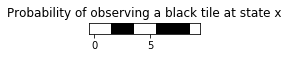

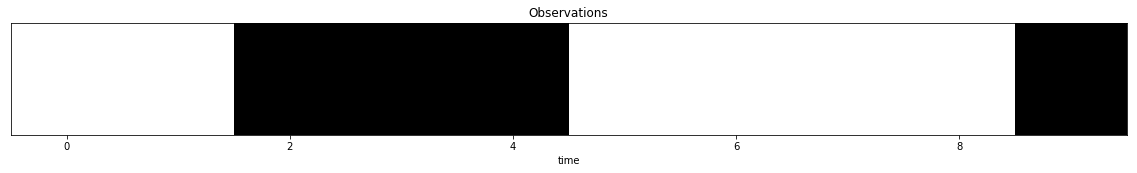

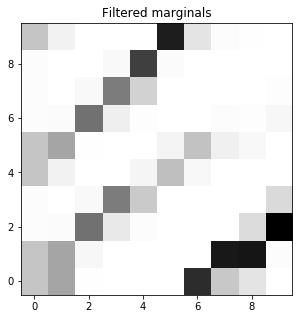

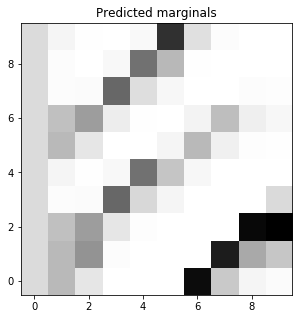

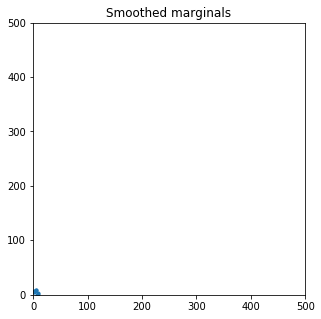

In [30]:
import numpy as np

from HiddenMarkovModel import *

import matplotlib.pylab as plt

# Number of tiles
S = 10

# Probability of staying on the same tile
ep = 0.1

# Probability of making an arbitrary jump
kidnap = 0.0

# Probability of correct observation
a = 0.9

# Set up the transition matrix
idx = [i for i in range(1,S)]+[0]
I = np.diag(np.ones(S))
A = (1-kidnap)*(ep*I + (1-ep)*I[:,idx]) + kidnap*np.ones((S,S))/S
C = np.zeros((2,S))

# Set up the observation matrix
c = a*np.random.randint(0,2, S) + (1-a)*np.ones(S)/2
C = np.array([c,1-c])

# Prior
p0 = np.ones(S)/S
#p0 = np.random.rand(S)
p0 = p0/sum(p0)

#hm2 = HMM(p0, A2, C)

T = 500
#y,x = hm2.generate_sequence(T)
xs = list()
hm = HMM(p0, A, C)
y,x = hm.generate_sequence(S)

log_alpha, log_alpha_pred = hm.forward(y)
log_gamma = hm.forward_backward_smoother(y)
xs = hm.viterbi(y)

alpha = normalize_exp(log_alpha, axis=0)
alpha_pred = normalize_exp(log_alpha_pred, axis=0)
gam = normalize_exp(log_gamma, axis=0)


plt.figure(figsize=(hm.S//5,1))
plt.imshow(C[1,:].reshape(1,hm.S), interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.set_yticks([])
ax.invert_yaxis()
plt.title('Probability of observing a black tile at state x')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(y.reshape(1,len(y)), interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.set_yticks([])
ax.invert_yaxis()
plt.title('Observations')
plt.xlabel('time')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(alpha, interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.invert_yaxis()
plt.title('Filtered marginals')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(alpha_pred, interpolation='nearest', cmap='gray_r')
ax = plt.gca()
ax.invert_yaxis()
plt.title('Predicted marginals')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(gam, interpolation='nearest', cmap='gray_r')
plt.plot(xs,'wo')
plt.plot(x,'.')
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlim((-0.5,T-0.5))
ax.set_ylim((-0.5,T-0.5))
plt.title('Smoothed marginals')

plt.show()